In [1]:
## Python Core
import datetime
import re
import math
from IPython.display import Markdown as md

## Data manipulation
import pandas as pd
import numpy as np


## Data Vizualization
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns

## Scikit
from sklearn.preprocessing import MinMaxScaler




# Questions

* How is interest applied?
* Is there a moratorium period? In which case what is the delinquency status?
* Why is first_payment_date at the time of origination and first monthly_reporting_period different?
* Why are some of the loan ages missing?
* What is the relation between loan age and monthly_reporting_period?
* A loan maybe be modified, in which case loan age re-starts
* What is deferred UPB?
* What is note rate?
* What is super-conforming?


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:,.7f}'.format)
pd.set_option('display.max_colwidth', None)

In [3]:
PROJECT_PATH = "E:/Projects/PyCharmProjects/credit_risk_analysis_adhoc"

In [4]:
quarters = {
    2014: range(1, 3),
    # 2015: range(1, 5),
    # 2016: range(1, 5),
    # 2017: range(1, 5),
    # 2018: range(1, 5),
    # 2019: range(1, 3),
}

In [5]:
def clean_feature_name(text):
    text = text.lower()
    text = re.sub(r"\(.*\)", "", text)
    text = re.sub(r"[^a-z]", " ", text)
    text = text.strip()
    text = re.sub(r"\s+", "_", text)
    return text
def state_to_num_days(state):
        if state >= 0:
            start = state*30
            end = (((state+1)*30)-1)
            return f"{start}-{end}"
        else:
            return 'RA'

In [6]:
state_to_num_days(11)


'330-359'

# Import Loan Origination Data

In [7]:
loan_characteristic_columns_original_format = """Credit Score
First Payment Date
First Time Homebuyer Flag
Maturity Date
Metropolitan Statistical Area (MSA) Or Metropolitan Division
Mortgage Insurance Percentage (MI %)
Number of Units
Occupancy Status
Original Combined Loan-to-Value (CLTV)
Original Debt-to-Income (DTI) Ratio
Original UPB
Original Loan-to-Value (LTV)
Original Interest Rate
Channel
Prepayment Penalty Mortgage (PPM) Flag
Amortization Type (Formerly Product Type)
Property State
Property Type
Postal Code
Loan Sequence Number
Loan Purpose
Original Loan Term
Number of Borrowers
Seller Name
Servicer Name
Super Conforming Flag
Pre-HARP Loan Sequence Number
Program Indicator
HARP Indicator
Property Valuation Method
Interest Only (I/O) Indicator"""
loan_characteristic_columns_original_format = loan_characteristic_columns_original_format.split("\n")
loan_characteristic_columns = [clean_feature_name(loan_char_column) for loan_char_column in loan_characteristic_columns_original_format]

## Read Files

In [8]:
loan_origination_files = [f"{PROJECT_PATH}/data/raw/freddie_mac/origination_data/historical_data_{year}Q{q}.txt" for year in quarters for q in quarters[year]]

print("Origination Files")
pprint(loan_origination_files)

Origination Files
['E:/Projects/PyCharmProjects/credit_risk_analysis_adhoc/data/raw/freddie_mac/origination_data/historical_data_2014Q1.txt',
 'E:/Projects/PyCharmProjects/credit_risk_analysis_adhoc/data/raw/freddie_mac/origination_data/historical_data_2014Q2.txt']


In [9]:
loan_origination_df = []
for loan_origin_filename in loan_origination_files:
    loan_origination_quarter_df = pd.read_csv(loan_origin_filename, delimiter="|", header=None)
    loan_origination_df.append(loan_origination_quarter_df)
    
loan_origination_df = pd.concat(loan_origination_df, ignore_index=True)
loan_origination_df.columns = loan_characteristic_columns

loan_origination_df["origination_quarter"] = [loan_sequence_number[1:5] for loan_sequence_number in loan_origination_df["loan_sequence_number"].to_numpy()]

In [10]:
loan_origination_df["first_payment_date"] = pd.to_datetime(loan_origination_df["first_payment_date"],
                                                    format="%Y%m").dt.date
loan_origination_df["maturity_date"] = pd.to_datetime(loan_origination_df["maturity_date"],
                                               format="%Y%m").dt.date
# loan_origination_df['metropolitan_statistical_area_or_metropolitan_division'] = loan_origination_df['metropolitan_statistical_area_or_metropolitan_division'].astype(str)


In [11]:
loan_origination_df.replace({
    "credit_score": {9999: None},
    "first_time_homebuyer_flag": {'9': None},
    "mortgage_insurance_percentage": {0: "no_MI", 
                                    999: None},
    "number_of_units": {99: None},
    "occupancy_status": {"P": "primary_residence", 
                       "I": "investment_property",
                       "S": "second_home",
                       '9': None},

    "original_combined_loan_to_value": {999: None},
    "original_debt_to_income_ratio": {999: None},
    "original_loan_to_value": {999: None},
    "channel": {"R": "retail",
              "B": "broker",
              "C": "correspondent",
              "T": "TPO_not_specified",
              '9': None},
    "prepayment_penalty_mortgage_flag": {"Y": "PPM",
                                         "N": "NOT_PPM"
                                        },
    "amortization_type": {"FRM": "fixed_rate_mortgage",
                          "ARM": "adjustable_rate_mortgage"},
    "property_type": {"CO": "condo",
                      "PU": "PUD",
                      "MH": "manufactured_housing",
                      "SF": "single_family",
                      "CP": "co_op",
                      "99": None
                     },
    "loan_purpose": {"P":"purchase",
                     "C": "refinance_cash_out",
                     "N": "refinance_no_cash_out",
                     "R": "refinance_not_specified",
                     '9': None
                    },
    "super_conforming_flag": {" ": "N"},
    "number_of_borrowers": {99: None},
    "program_indicator": {"H": "home_possible",
                          "F": "HFA_advantage",
                          "R": "Refi_possible",
                          9: None},
    "harp_indicator": {"Y": "relief_refinance_loan",
                       " ": "non_relief_refinance_loan",
                       np.float64(None): None
                      },
    "property_valuation_method": {1: "ACE_loans",
                                  2: "full_appraisal",
                                  3: "other_appraisals",
                                  9: None
                                 },
    "property_valuation_method": {9: None}
},
                     inplace=True
                    )

In [12]:
loan_origination_df.head()

,credit_score,first_payment_date,first_time_homebuyer_flag,maturity_date,metropolitan_statistical_area_or_metropolitan_division,mortgage_insurance_percentage,number_of_units,occupancy_status,original_combined_loan_to_value,original_debt_to_income_ratio,original_upb,original_loan_to_value,original_interest_rate,channel,prepayment_penalty_mortgage_flag,amortization_type,property_state,property_type,postal_code,loan_sequence_number,loan_purpose,original_loan_term,number_of_borrowers,seller_name,servicer_name,super_conforming_flag,pre_harp_loan_sequence_number,program_indicator,harp_indicator,property_valuation_method,interest_only_indicator,origination_quarter
0,629,2014-05-01,N,2029-04-01,"17,300.0000000",no_MI,1,primary_residence,77,45,324000,71,3.8750000,retail,NOT_PPM,fixed_rate_mortgage,KY,single_family,42200,F14Q10000001,refinance_cash_out,180,2,Other sellers,Other servicers,NaN,NaN,None,None,None,N,14Q1
1,770,2014-04-01,N,2029-03-01,NaN,12,1,primary_residence,89,30,65000,89,3.3750000,retail,NOT_PPM,fixed_rate_mortgage,NY,single_family,13600,F14Q10000002,refinance_no_cash_out,180,2,Other sellers,Other servicers,NaN,NaN,None,None,None,N,14Q1
2,674,2014-03-01,N,2029-02-01,NaN,no_MI,1,primary_residence,89,None,182000,76,3.3750000,retail,NOT_PPM,fixed_rate_mortgage,MI,single_family,49200,F14Q10000003,refinance_no_cash_out,180,1,Other sellers,Other servicers,NaN,F06Q30104219,None,relief_refinance_loan,None,N,14Q1
3,717,2014-04-01,N,2044-03-01,"39,300.0000000",no_MI,1,investment_property,77,41,107000,77,5.2500000,retail,NOT_PPM,fixed_rate_mortgage,RI,single_family,2800,F14Q10000004,purchase,360,2,Other sellers,"LAKEVIEW LOAN SERVICING, LLC",NaN,NaN,None,None,None,N,14Q1
4,813,2014-05-01,Y,2044-04-01,"19,780.0000000",30,1,primary_residence,95,32,165000,95,4.1250000,retail,NOT_PPM,fixed_rate_mortgage,IA,single_family,50300,F14Q10000005,purchase,360,1,Other sellers,Other servicers,NaN,NaN,None,None,None,N,14Q1


In [13]:
missing_char_data = pd.DataFrame({
    "count": loan_origination_df.isna().sum(),
    "pct_missing": loan_origination_df.isna().mean()*100
})
missing_char_data[missing_char_data.pct_missing>0]

,count,pct_missing
credit_score,74,0.0144355
first_time_homebuyer_flag,11,0.0021458
metropolitan_statistical_area_or_metropolitan_division,71827,14.0116069
mortgage_insurance_percentage,1,0.0001951
original_combined_loan_to_value,16,0.0031212
original_debt_to_income_ratio,89616,17.4817849
original_loan_to_value,15,0.0029261
super_conforming_flag,496734,96.9000732
pre_harp_loan_sequence_number,423026,82.5215313
program_indicator,512625,100.0000000


In [14]:
# loan_char_cols_to_remove = [
#     'program_indicator',
#     'property_valuation_method']

In [15]:
# loan_origination_df.drop(columns=loan_char_cols_to_remove, inplace=True)

# Import Loan Performance Data

In [16]:
loan_perf_columns_original_format = """Loan Sequence Number
Monthly Reporting Period
Current Actual UPB
Current Loan Delinquency Status
Loan Age
Remaining Months to Legal Maturity
Defect Settlement Date
Modification Flag
Zero Balance Code
Zero Balance Effective Date
Current Interest Rate
Current Deferred UPB
Due Date of Last Paid Installment (DDLPI)
MI Recoveries
Net Sales Proceeds
Non MI Recoveries
Expenses
Legal Costs
Maintenance and Preservation Costs
Taxes and Insurance
Miscellaneous Expenses
Actual Loss Calculation
Modification Cost
Step Modification Flag
Deferred Payment Plan
Estimated Loan-to-Value (ELTV)
Zero Balance Removal UPB
Delinquent Accrued Interest
Delinquency Due to Disaster
Borrower Assistance Status Code
Current Month Modification Cost
Interest Bearing UPB"""
loan_perf_columns_original_format = loan_perf_columns_original_format.split("\n")
loan_performance_columns = [clean_feature_name(loan_performance_column) 
                            for loan_performance_column in loan_perf_columns_original_format]

In [17]:
loan_performance_files = [f"{PROJECT_PATH}/data/raw/freddie_mac/performance_data/historical_data_time_{year}Q{q}.txt" for year in quarters for q in quarters[year]]

print("Performance Files")
pprint(loan_performance_files)

Performance Files
['E:/Projects/PyCharmProjects/credit_risk_analysis_adhoc/data/raw/freddie_mac/performance_data/historical_data_time_2014Q1.txt',
 'E:/Projects/PyCharmProjects/credit_risk_analysis_adhoc/data/raw/freddie_mac/performance_data/historical_data_time_2014Q2.txt']


## Read Files

In [18]:
loan_performance_df = []
for loan_performance_filename in loan_performance_files:
    loan_performance_quarter_df = pd.read_csv(loan_performance_filename, 
                                              delimiter="|",
                                              header=None)
    loan_performance_df.append(loan_performance_quarter_df)
    
loan_performance_df = pd.concat(loan_performance_df, ignore_index=True)
loan_performance_df.columns = loan_performance_columns

C:\Users\ashwi\anaconda3\envs\Credit_Risk_Modeling\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (3,7,23,24,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\ashwi\anaconda3\envs\Credit_Risk_Modeling\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (3,7,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
loan_performance_df["monthly_reporting_period"] = pd.to_datetime(loan_performance_df["monthly_reporting_period"], 
                                                                 format="%Y%m").dt.date

## Remove Null Values

In [23]:
loan_performance_df.replace({"modification_flag": {"Y": "current_period_modification",
                                                   "P": "prior_period_modification",
                                                   " ": "not_modified"
                                                  },
                             "zero_balance_code": {1.0: "voluntary_payoff",
                                                   2.0: "third_party_sale",
                                                   3.0: "charge_off",
                                                   9.0: "reo_disposition",
                                                   96.0: "repurchase_prior_to_property_disposition",
                                                   15.0: "reperforming_sale"
                                                  },
                             "zero_balance_effective_date": {"      ": "not_applicable"},
                             "net_sale_proceeds": {"U": "unknown"},
                             "step_modification_flag": {"Y": "current_period_step_mod",
                                                        "N": "current_non_step_mod",
                                                        " ": "not_a_current_period_mod"},
                             "deferred_payment_plan": {"Y": "current_period_deferred_plan",
                                                       "P": "prior_period_deferred_plan",
                                                       " ": "no_deferred_plan"
                                                      },
                             "estimated_loan_to_value": {999: "unknown",
                                                         " ": "data_not_available"
                                                        },
                             "delinquency_due_to_disaster": {"Y": "delinquency_due_to_disaster"},
                             "borrower_assistance_status_code": {"F": "forbearance",
                                                                 "R": "repayment",
                                                                 "T": "trial_period"                                                                 
                                                                }
                             
                             },
                             inplace=True
                            )

In [ ]:
# loan_performance_df.drop(columns=loan_performance_null_columns, 
#                          inplace=True)

In [24]:
delinquency_values = list(loan_performance_df["current_loan_delinquency_status"].unique())
delinquency_values.remove('RA')

delinquency_map = {val: int(val) for val in delinquency_values if isinstance(val, str)}
delinquency_map['RA'] = -1
delinquency_map['XX'] = None
delinquency_map['   '] = None

loan_performance_df.replace({"current_loan_delinquency_status": delinquency_map}, inplace=True)
loan_performance_df["current_loan_delinquency_status"] = loan_performance_df["current_loan_delinquency_status"].astype(int)

In [25]:
missing_perf_data = pd.DataFrame({
    "count": loan_performance_df.isna().sum(),
    "pct_missing": loan_performance_df.isna().mean()*100
})
missing_perf_data[missing_perf_data.pct_missing>0]

,count,pct_missing
defect_settlement_date,30102696,99.9971797
modification_flag,29975610,99.5750168
zero_balance_code,29711382,98.6972863
zero_balance_effective_date,29711382,98.6972863
due_date_of_last_paid_installment,29951218,99.4939898
mi_recoveries,30100243,99.9890312
net_sales_proceeds,30100229,99.9889847
non_mi_recoveries,30100243,99.9890312
expenses,30100243,99.9890312
legal_costs,30100243,99.9890312


# Merge Data

In [26]:
loan_df = pd.merge(loan_origination_df, loan_performance_df, on="loan_sequence_number", how="inner")

In [27]:
loan_df.head()

,credit_score,first_payment_date,first_time_homebuyer_flag,maturity_date,metropolitan_statistical_area_or_metropolitan_division,mortgage_insurance_percentage,number_of_units,occupancy_status,original_combined_loan_to_value,original_debt_to_income_ratio,original_upb,original_loan_to_value,original_interest_rate,channel,prepayment_penalty_mortgage_flag,amortization_type,property_state,property_type,postal_code,loan_sequence_number,loan_purpose,original_loan_term,number_of_borrowers,seller_name,servicer_name,super_conforming_flag,pre_harp_loan_sequence_number,program_indicator,harp_indicator,property_valuation_method,interest_only_indicator,origination_quarter,monthly_reporting_period,current_actual_upb,current_loan_delinquency_status,loan_age,remaining_months_to_legal_maturity,defect_settlement_date,modification_flag,zero_balance_code,zero_balance_effective_date,current_interest_rate,current_deferred_upb,due_date_of_last_paid_installment,mi_recoveries,net_sales_proceeds,non_mi_recoveries,expenses,legal_costs,maintenance_and_preservation_costs,taxes_and_insurance,miscellaneous_expenses,actual_loss_calculation,modification_cost,step_modification_flag,deferred_payment_plan,estimated_loan_to_value,zero_balance_removal_upb,delinquent_accrued_interest,delinquency_due_to_disaster,borrower_assistance_status_code,current_month_modification_cost,interest_bearing_upb
0,629,2014-05-01,N,2029-04-01,"17,300.0000000",no_MI,1,primary_residence,77,45,324000,71,3.8750000,retail,NOT_PPM,fixed_rate_mortgage,KY,single_family,42200,F14Q10000001,refinance_cash_out,180,2,Other sellers,Other servicers,NaN,NaN,None,None,None,N,14Q1,2014-04-01,"324,000.0000000",0,0,180,NaN,NaN,NaN,NaN,3.8750000,0.0000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"324,000.0000000"
1,629,2014-05-01,N,2029-04-01,"17,300.0000000",no_MI,1,primary_residence,77,45,324000,71,3.8750000,retail,NOT_PPM,fixed_rate_mortgage,KY,single_family,42200,F14Q10000001,refinance_cash_out,180,2,Other sellers,Other servicers,NaN,NaN,None,None,None,N,14Q1,2014-05-01,"322,000.0000000",0,1,179,NaN,NaN,NaN,NaN,3.8750000,0.0000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"322,000.0000000"
2,629,2014-05-01,N,2029-04-01,"17,300.0000000",no_MI,1,primary_residence,77,45,324000,71,3.8750000,retail,NOT_PPM,fixed_rate_mortgage,KY,single_family,42200,F14Q10000001,refinance_cash_out,180,2,Other sellers,Other servicers,NaN,NaN,None,None,None,N,14Q1,2014-06-01,"321,000.0000000",0,2,178,NaN,NaN,NaN,NaN,3.8750000,0.0000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"321,000.0000000"
3,629,2014-05-01,N,2029-04-01,"17,300.0000000",no_MI,1,primary_residence,77,45,324000,71,3.8750000,retail,NOT_PPM,fixed_rate_mortgage,KY,single_family,42200,F14Q10000001,refinance_cash_out,180,2,Other sellers,Other servicers,NaN,NaN,None,None,None,N,14Q1,2014-07-01,"320,000.0000000",0,3,177,NaN,NaN,NaN,NaN,3.8750000,0.0000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"320,000.0000000"
4,629,2014-05-01,N,2029-04-01,"17,300.0000000",no_MI,1,primary_residence,77,45,324000,71,3.8750000,retail,NOT_PPM,fixed_rate_mortgage,KY,single_family,42200,F14Q10000001,refinance_cash_out,180,2,Other sellers,Other servicers,NaN,NaN,None,None,None,N,14Q1,2014-08-01,"320,000.0000000",0,4,176,NaN,NaN,NaN,NaN,3.8750000,0.0000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"320,000.0000000"


In [43]:
loan_df.zero_balance_code.value_counts()

voluntary_payoff                            387767
reperforming_sale                             1267
reo_disposition                                904
repurchase_prior_to_property_disposition       825
charge_off                                     340
third_party_sale                               281
Name: zero_balance_code, dtype: int64

In [ ]:
loan_df.zero_balance_code.isin([""])

In [28]:
loan_df.sort_values(by=["loan_sequence_number", "monthly_reporting_period"], inplace=True)

# A year of delinquency will be considered default

* Once a loan reaches a year of delinquency, there is little chance it goes back to any other less delinquent status
* Similarly once a loan reaches REO Acquisition status, there is no chance it goes back to any other status
* Model will not make predictions on any loan whose current_loan_delinquency_status is 12 or more
* REO to any other status does not exist, no changes need to be made
* current_loan_delinquency_status=12 has some performance data after this status, we shall drop these since we won't make predictions on these

In [29]:
loan_df = loan_df[loan_df.current_loan_delinquency_status <= 12]

# Initial Statuses for Target Variable

* According to the transition matrix we will have 13 statuses
    * REO Acquisition
    * 0-29 or Current
    * 30-59 days delinquent
    * 60-89 days delinquent
    * ..
    * 330-359 days delinquent
    * \>=360 days delinquent
* Given we are in one of the statuses, the task is to predict which of the other statuses will the loan transition to in the next 3 to 6 months
    * Current to Current
    * Current to 30-59 days delinquent
    * Current to 60-89 days delinquent
    * 30-59 days delinquent to 60-89 days delinquent etc

# We cannot predict without enough performance data

* The model helps to solve the question
    * The approved loan, based on its performance in the past 6,8 or 12 months, is it likely change it's delinquency state?
    * not: Should we approve the loan at origination? 
        * That would be the task of another model, which assumes we only have origination data
* We choose 12 months as the sufficient amount of loan age, that enables prediction
* The model cannot predictions on loans with age [0-12]

In [ ]:
# loan_df["month_3_loan_delinquency_status"] = "Unknown"
# loan_df["month_6_loan_delinquency_status"] = "Unknown"

In [ ]:
# loan_df_groups = loan_df.groupby("loan_sequence_number")
# def get_future_row(loan_sequence_number, current_age, months):
#     try:
#         single_loan_df = loan_df_groups.get_group(loan_sequence_number)
#         print()

#         future_age = current_age + months

#         ## If loan age ends before the future_age, we get the last row for that loan
#         if future_age > single_loan_df.loan_age.max():
#             future_age = single_loan_df.loan_age.max()

#         future_row = single_loan_df[single_loan_df.loan_age == future_age]
#         future_row = future_row.iloc[0]
#         future_row = future_row.to_dict()
#         return future_row
#     except Exception as E:
#         print(loan_sequence_number)
#         print(current_age, months)
#         print(single_loan_df.shape)
#         print(E)
#         raise Exception("Somethings wrong")
        

In [ ]:
# loan_df_groups = loan_df.groupby("loan_sequence_number")
# def get_future_row(loan_sequence_number, current_age, months):
#     try:
#         single_loan_df = loan_df_groups.get_group(loan_sequence_number)
#         # print(loan_sequence_number, current_age, months, single_loan_df.shape)
#         future_age = current_age + months

#         ## If loan age ends before the future_age, we get the last row for that loan
#         if future_age > single_loan_df.loan_age.max():
#             future_age = single_loan_df.loan_age.max()

#         future_row = single_loan_df[single_loan_df.loan_age == future_age]
#         future_row = future_row.iloc[0]
#         future_row = future_row.to_dict()
#         return future_row
#     except Exception as e:
#         print(loan_sequence_number, current_age, months, single_loan_df.shape)
        

In [ ]:
# for idx, row in loan_df.iterrows():
#     row = row.to_dict()
#     if row["loan_age"] < 12:
#         month_3_loan_delinquency_status = "Unknown"
#         month_6_loan_delinquency_status = "Unknown"
#     else:
#         month_3_row = get_future_row(loan_sequence_number=row["loan_sequence_number"],
#                                      current_age=row["loan_age"],
#                                      months=3)
#         loan_df.at[idx, 'month_3_loan_delinquency_status'] = month_3_row["current_loan_delinquency_status"]
#         month_6_row = get_future_row(loan_sequence_number=row["loan_sequence_number"],
#                                      current_age=row["loan_age"],
#                                      months=6)
#         loan_df.at[idx, 'month_6_loan_delinquency_status'] = month_6_row["current_loan_delinquency_status"]
        
#         # print("#"*50)
#         # print("\n current")
#         # pprint(row)
#         # print("\n month 3")
#         # pprint(month_3_row)
#         # print("\n month 6")
#         # pprint(month_6_row)

# Loans that end on current

In [30]:
def ends_on_current(single_loan_df):
    return single_loan_df[single_loan_df.monthly_reporting_period == single_loan_df.monthly_reporting_period.max()].iloc[0].current_loan_delinquency_status == 0


delinquency_status = loan_df.groupby("loan_sequence_number").apply(ends_on_current)

In [31]:
non_delinquent_loans = delinquency_status[delinquency_status]
delinquent_loans = delinquency_status[~delinquency_status]

# Loans with different MAX delinquency

In [32]:
def max_delinquency(current_loan_delinquency_status):
    if current_loan_delinquency_status.min() == -1:
        return -1
    return current_loan_delinquency_status.max()
loan_to_max_delinquency_status = loan_df.groupby("loan_sequence_number").current_loan_delinquency_status.apply(max_delinquency)

In [35]:
loan_to_max_delinquency_status.value_counts()

 0     449789
 1      36156
 2       7462
 12      5025
 3       3439
 5       1999
 4       1937
 6       1591
 7       1193
-1        942
 8        898
 11       758
 9        752
 10       679
Name: current_loan_delinquency_status, dtype: int64

In [33]:
num_loans_for_display = 5
seed = 42

max_loan_delinquency_status:  -1


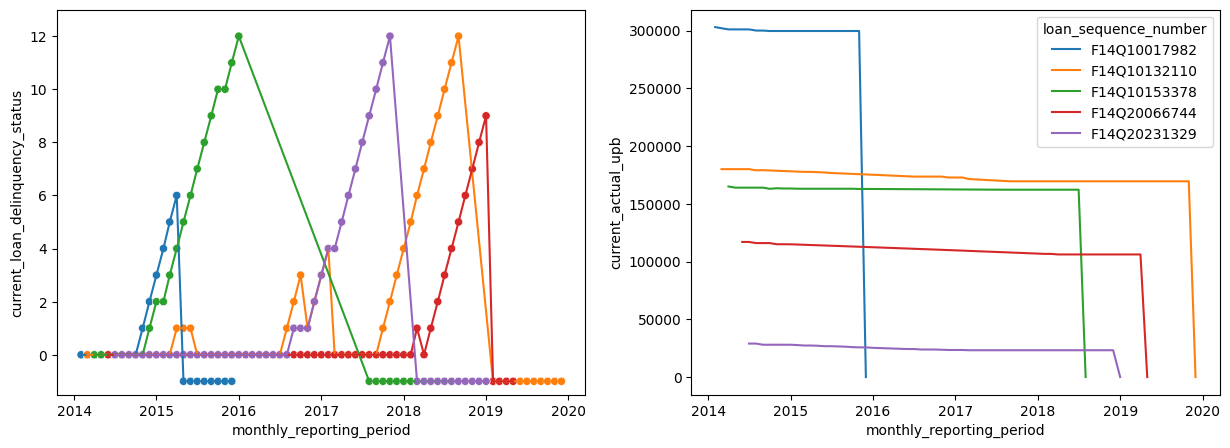

max_loan_delinquency_status:  0


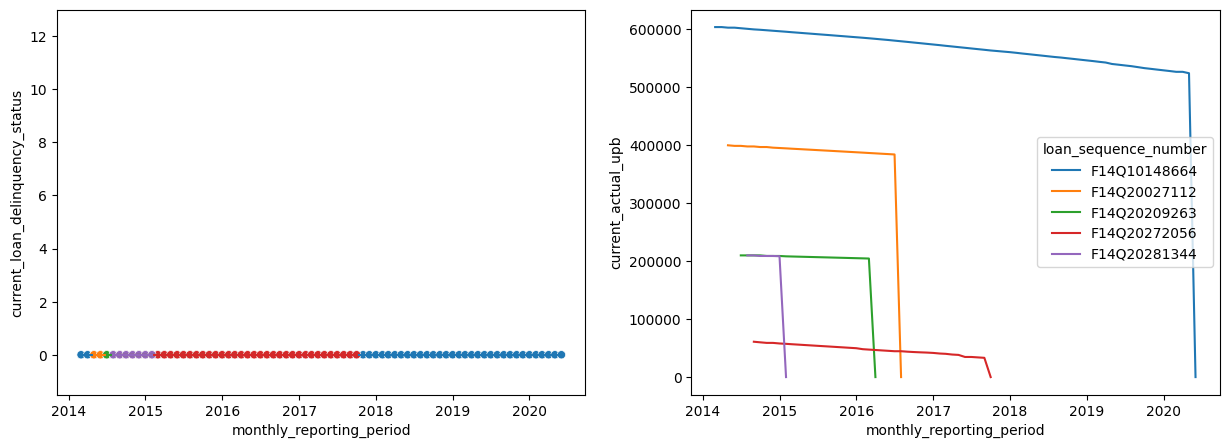

max_loan_delinquency_status:  1


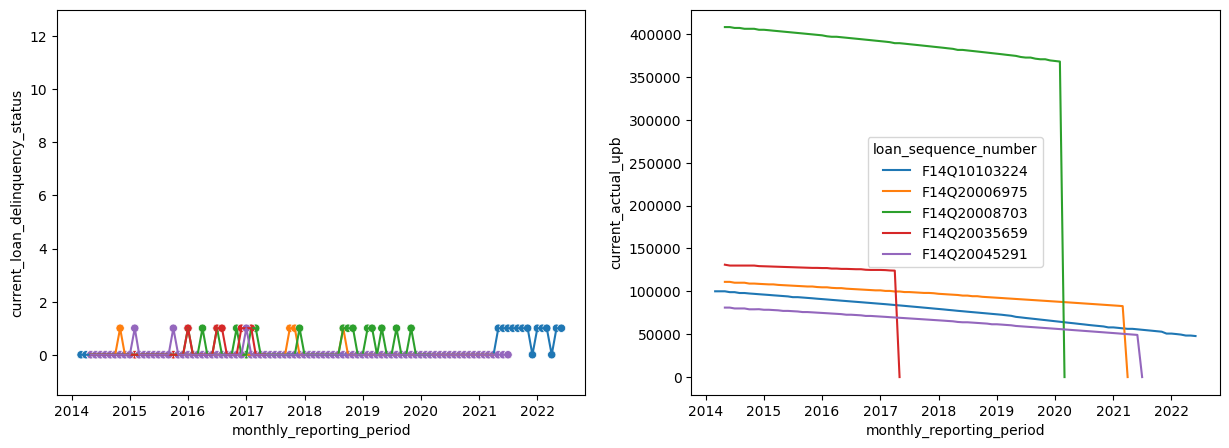

max_loan_delinquency_status:  2


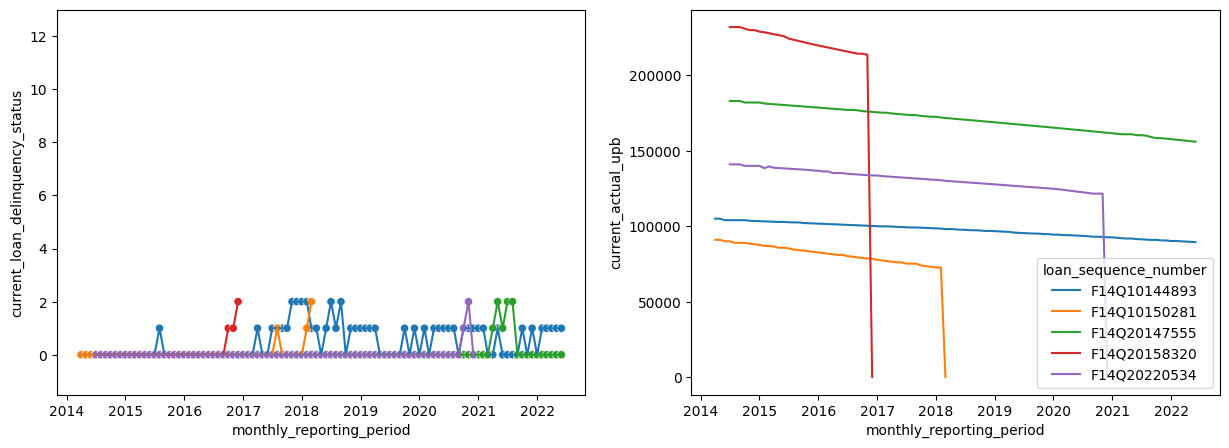

max_loan_delinquency_status:  3


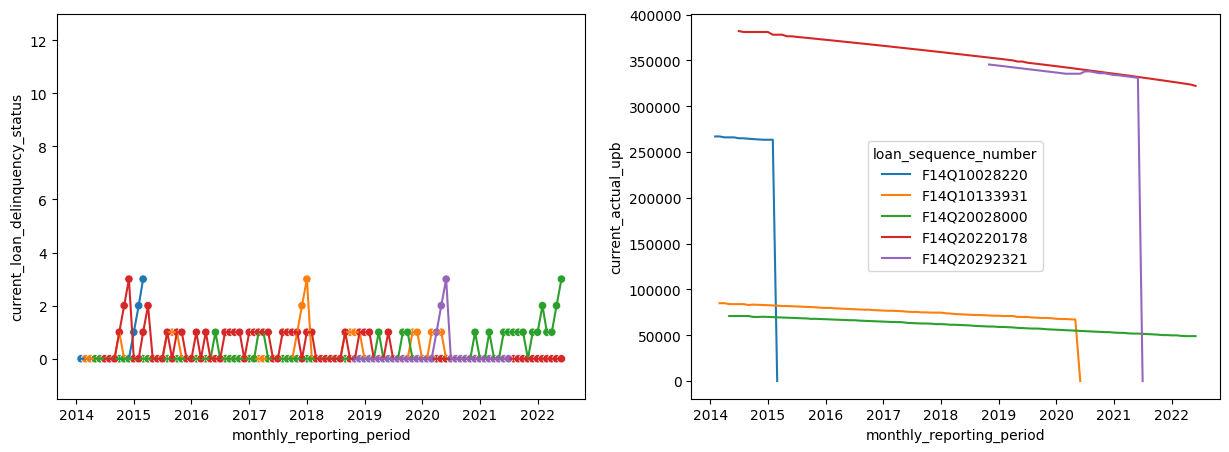

max_loan_delinquency_status:  4


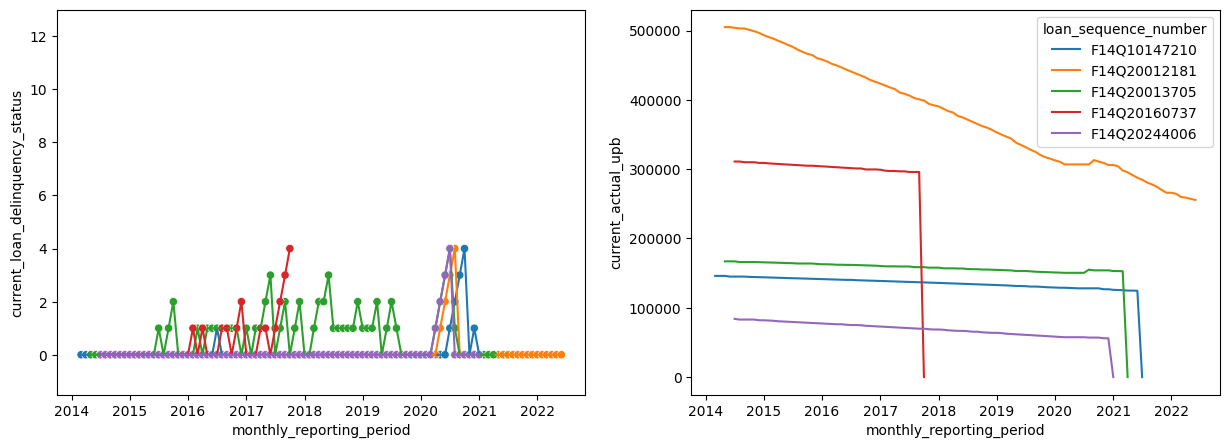

max_loan_delinquency_status:  5


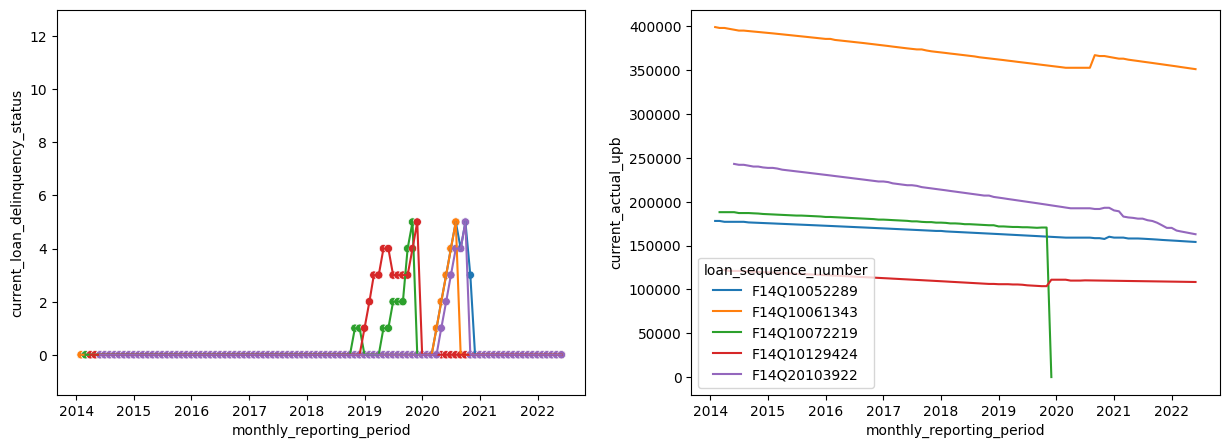

max_loan_delinquency_status:  6


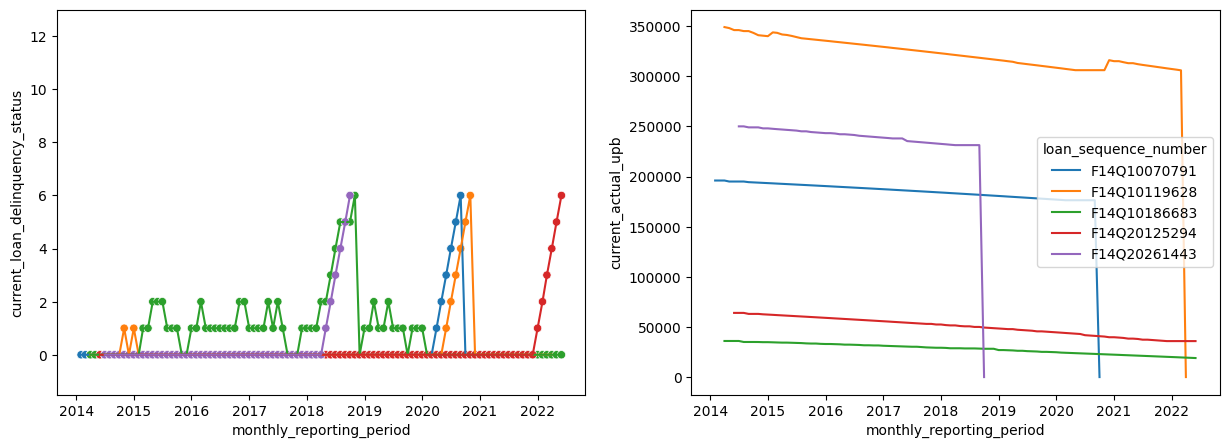

max_loan_delinquency_status:  7


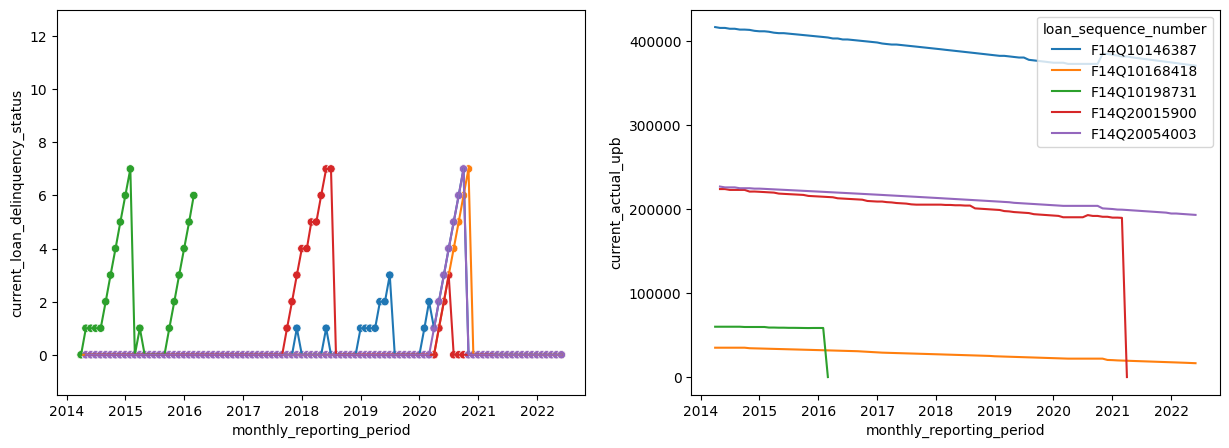

max_loan_delinquency_status:  8


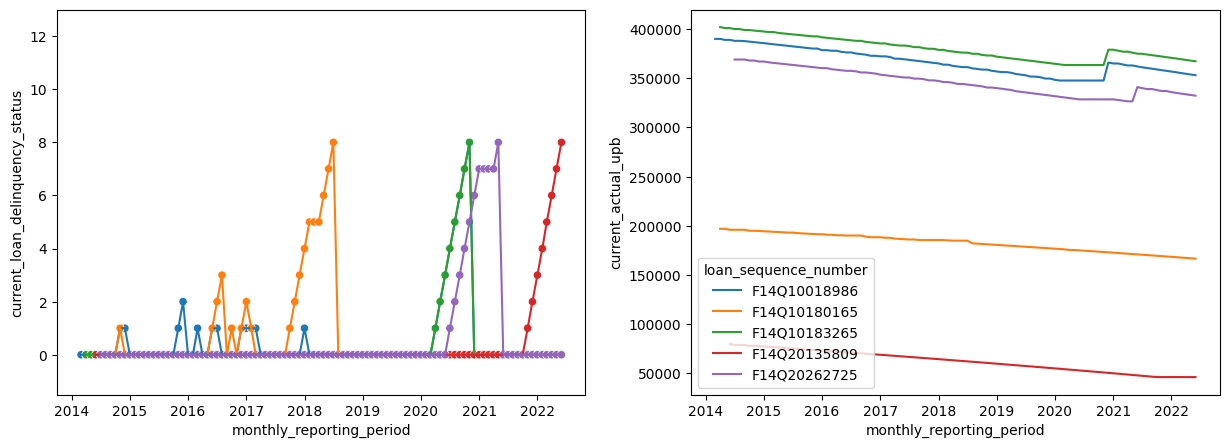

max_loan_delinquency_status:  9


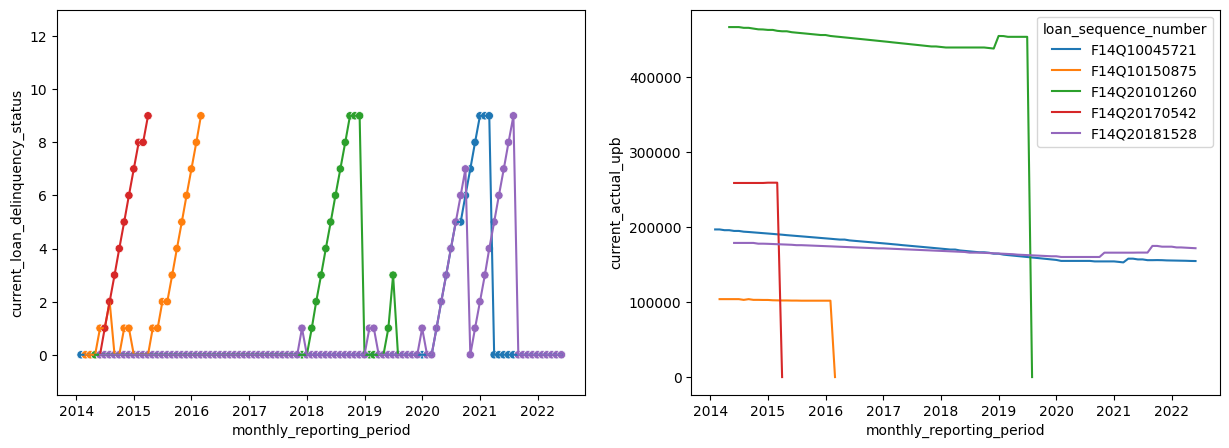

max_loan_delinquency_status:  10


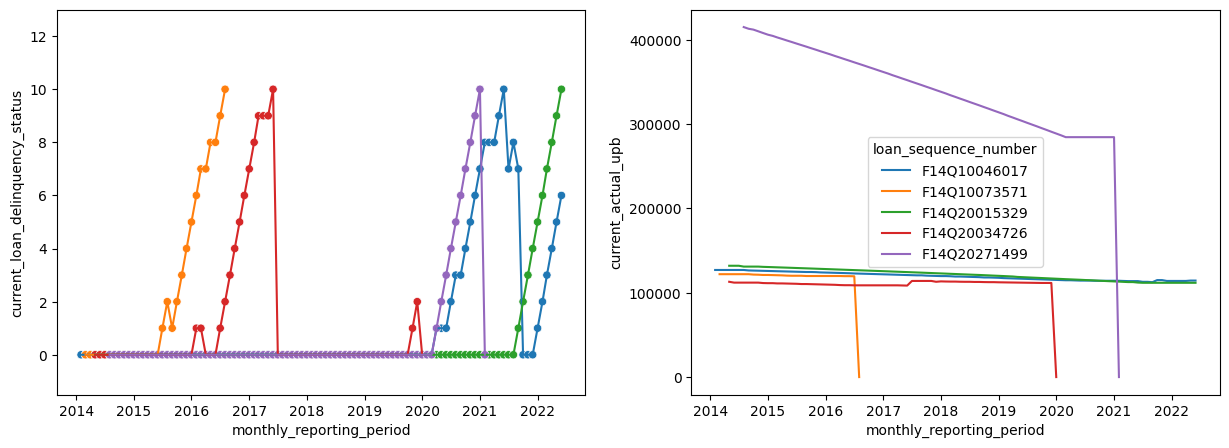

max_loan_delinquency_status:  11


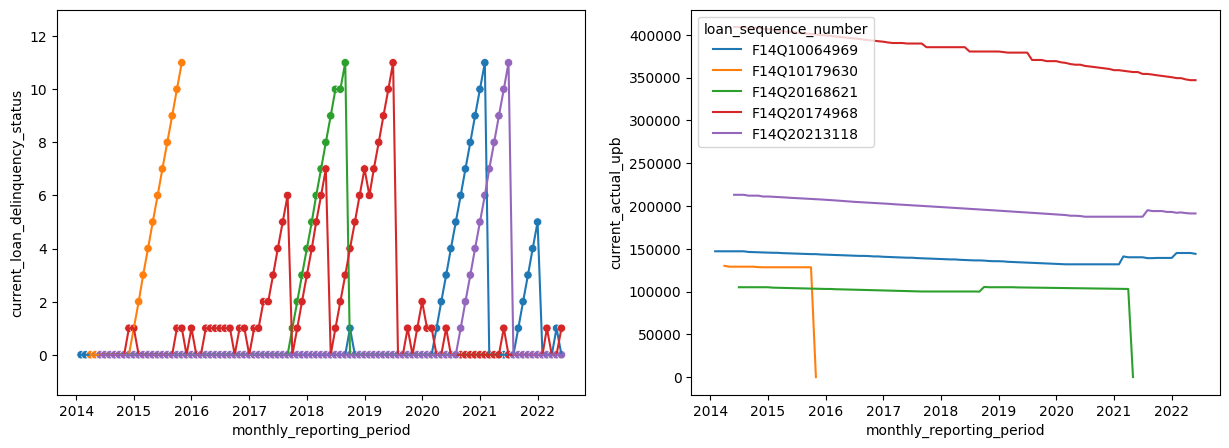

max_loan_delinquency_status:  12


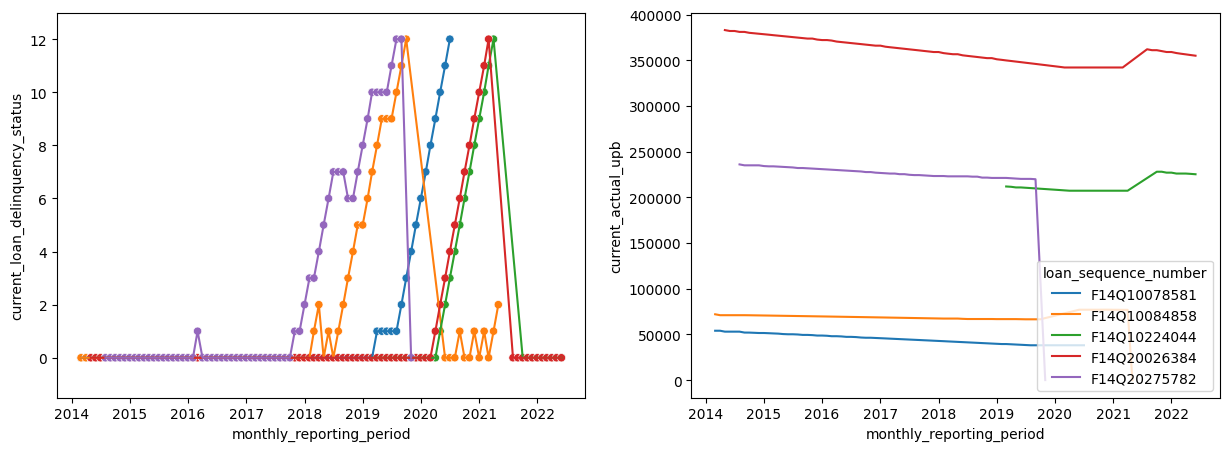

In [42]:
loan_delinquency_statuses = [-1] + [i for i in range(0, 13)]

for loan_delinquency_status in loan_delinquency_statuses:
    delinquency_status_sequence_numbers = loan_to_max_delinquency_status[loan_to_max_delinquency_status == loan_delinquency_status].sample(num_loans_for_display, random_state=seed).index
    delinquency_status_loan_sample = loan_df[loan_df.loan_sequence_number.isin(delinquency_status_sequence_numbers)]
    
    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
    print("max_loan_delinquency_status: ", loan_delinquency_status)
    ax = sns.lineplot(x="monthly_reporting_period",
                      y="current_loan_delinquency_status", 
                      hue="loan_sequence_number",
                      ax=axs[0],
                      data=delinquency_status_loan_sample,
                      legend=False)
    ax = sns.scatterplot(x="monthly_reporting_period",
                         y="current_loan_delinquency_status", 
                         hue="loan_sequence_number",
                         ax=axs[0],
                         data=delinquency_status_loan_sample,
                         legend=False
                        )
    ax.set_ylim([-1.5, 13])
    ax = sns.lineplot(x="monthly_reporting_period",
                      y="current_actual_upb", 
                      hue="loan_sequence_number",
                      ax=axs[1],
                      data=delinquency_status_loan_sample)
    plt.show()
    
    
    


In [ ]:
# output_filepath = f"{PROJECT_PATH}/data/processed/adhoc/_1-2-2-creating_labels_OUTPUT_DATA/labelled_long_2014Q1.parquet"
# loan_df.to_parquet(output_filepath)